Installation

In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

# Install OpenCV and Matplotlib
!pip install opencv-python matplotlib

In [18]:
import torch

# Check if GPU is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


Import Libraries

In [1]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# from torch.utils.data import DataLoader, Dataset
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset
from PIL import Image
from torchvision import transforms
import uuid
import torch.optim as optim 

Create Path

In [3]:
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [8]:
ANC_LATER_PATH = os.path.join('data', 'anchor_later')
POS_LATER_PATH = os.path.join('data', 'positive_later')

In [30]:
# os.makedirs(POS_LATER_PATH)
# os.makedirs(ANC_LATER_PATH)

In [31]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

In [ ]:
# Uncompress Tar GZ Labelled Faces in the Wild Dataset
!tar -xf lfw.tgz

In [ ]:
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [ ]:
# import uuid

In [ ]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

Capture Images

In [6]:
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

Data Augmentation

In [10]:
# Define the data augmentation function
def data_aug(img):
    data = []
    
    # Define augmentation transformations
    transform = transforms.Compose([
        transforms.RandomApply([transforms.ColorJitter(brightness=0.02)], p=1.0),  # Random brightness
        transforms.RandomApply([transforms.ColorJitter(contrast=0.4)], p=1.0),    # Random contrast
        transforms.RandomHorizontalFlip(p=0.5),  # Random flip
        transforms.Lambda(lambda x: random_jpeg_quality(x)),  # Random JPEG quality (custom function)
        transforms.Lambda(lambda x: random_saturation(x))  # Random saturation (custom function)
    ])

    for _ in range(9):  # Apply augmentation 9 times
        augmented_img = transform(img)
        data.append(augmented_img)
    
    return data

# Custom function for random JPEG quality (mimic TF's jpeg quality)
def random_jpeg_quality(img, min_quality=90, max_quality=100):
    quality = random.randint(min_quality, max_quality)
    # Simulate the effect of JPEG compression (this is an approximation)
    img = img.convert('RGB')
    img = np.array(img)
    img = Image.fromarray(img)
    return transforms.ToTensor()(img)

# Custom function for random saturation (mimic TF's saturation adjustment)
def random_saturation(img, lower=0.9, upper=1.0):
    saturation_factor = random.uniform(lower, upper)
    transform = transforms.ColorJitter(saturation=saturation_factor)
    return transform(img)


Data Augmentation for Positive data

In [11]:
# Loop through all files in the positive image directory
# for file_name in os.listdir(POS_PATH):
#     img_path = os.path.join(POS_PATH, file_name)
for file_name in os.listdir(POS_LATER_PATH):
    img_path = os.path.join(POS_LATER_PATH, file_name)
    
    # Read the image with OpenCV
    img = cv2.imread(img_path)
    
    # Convert BGR to RGB (OpenCV reads images in BGR format by default)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Convert the image to PIL Image format to apply transformations
    img = Image.fromarray(img)
    
    # Augment the image
    augmented_images = data_aug(img)  # This function returns a list of augmented images
    
    # Save each augmented image
    for image in augmented_images:
        # Convert back to numpy array and rescale to [0, 255]
        image = image.permute(1, 2, 0).numpy()  # Convert (C, H, W) to (H, W, C)
        image = np.uint8(image * 255)  # Rescale to [0, 255] and convert to uint8
        
        # Convert RGB back to BGR for OpenCV
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        # Save the augmented image with a unique filename
        augmented_image_path = os.path.join(POS_PATH, f'{uuid.uuid1()}.jpg')
        cv2.imwrite(augmented_image_path, image)


Data Augmentation for Anchor data

In [12]:
# for file_name in os.listdir(ANC_PATH):
#     img_path = os.path.join(ANC_PATH, file_name)
for file_name in os.listdir(ANC_LATER_PATH):
    img_path = os.path.join(ANC_LATER_PATH, file_name)
    
    # Read the image with OpenCV
    img = cv2.imread(img_path)
    
    # Convert BGR to RGB (OpenCV reads images in BGR format by default)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Convert the image to PIL Image format to apply transformations
    img = Image.fromarray(img)
    
    # Augment the image
    augmented_images = data_aug(img)  # This function returns a list of augmented images
    
    # Save each augmented image
    for image in augmented_images:
        # Convert back to numpy array and rescale to [0, 255]
        image = image.permute(1, 2, 0).numpy()  # Convert (C, H, W) to (H, W, C)
        image = np.uint8(image * 255)  # Rescale to [0, 255] and convert to uint8
        
        # Convert RGB back to BGR for OpenCV
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        # Save the augmented image with a unique filename
        augmented_image_path = os.path.join(ANC_PATH, f'{uuid.uuid1()}.jpg')
        cv2.imwrite(augmented_image_path, image)

Create Dataset Class

In [4]:
# Define the CustomDataset class
class CustomDataset(Dataset):
    def __init__(self, anchor_dir, positive_dir, negative_dir, transform=None):
        # Directories for the images
        self.anchor_files = [os.path.join(anchor_dir, f) for f in os.listdir(anchor_dir) if f.endswith('.jpg')][:5500]
        self.positive_files = [os.path.join(positive_dir, f) for f in os.listdir(positive_dir) if f.endswith('.jpg')][:5500]
        self.negative_files = [os.path.join(negative_dir, f) for f in os.listdir(negative_dir) if f.endswith('.jpg')][:5500]

        # Optional transform
        self.transform = transform

    # def preprocess(self, file_path):
    #     # Open the image file
    #     img = Image.open(file_path).convert('RGB')

    #     # Define preprocessing transformations
    #     transform = transforms.Compose([
    #         transforms.Resize((100, 100)),    # Resize to 100x100
    #         transforms.ToTensor(),            # Convert image to tensor and scale between 0 and 1
    #     ])

    #     # Apply transformations
    #     img = transform(img)
        
        # return img
    def preprocess(self, img_path):
        # Read the image using OpenCV
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB

        # Convert the image from NumPy array to PIL Image
        img = Image.fromarray(img)

        # Define the transformations
        transform = transforms.Compose([
            transforms.Resize((100, 100)),  # Resize to the required size
            transforms.ToTensor(),          # Convert to Tensor
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
        ])

        # Apply transformations
        img_tensor = transform(img)  # Add batch dimension
        return img_tensor

    def __len__(self):
        # Return the total number of images in all categories
        return len(self.anchor_files) + len(self.positive_files) + len(self.negative_files)

    def __getitem__(self, idx):
        # Total number of samples (anchor + positive + negative)
        total_samples = len(self.anchor_files) + len(self.positive_files) + len(self.negative_files)
    
        if idx < len(self.anchor_files):  # Anchor files
            img1_path = self.anchor_files[idx]
            img2_path = self.positive_files[idx]  # Assuming positive pair for simplicity
            label = 1  # Positive pair
        elif idx < len(self.anchor_files) + len(self.positive_files):  # Positive files
            img1_path = self.anchor_files[idx - len(self.anchor_files)]
            img2_path = self.positive_files[idx - len(self.anchor_files)]
            label = 1  # Positive pair
        else:  # Negative files
            img1_path = self.anchor_files[idx - len(self.anchor_files) - len(self.positive_files)]
            img2_path = self.negative_files[idx - len(self.anchor_files) - len(self.positive_files)]
            label = 0  # Negative pair
    
        # Preprocess the images
        img1 = self.preprocess(img1_path)
        img2 = self.preprocess(img2_path)
    
        return img1, img2, label


    def preprocess_twin(self, input_img, validation_img, label):
        return (self.preprocess(input_img), self.preprocess(validation_img), label)

    def create_data(self):
        # Create dataset for positive samples: label = 1 for positives
        positive_data = []
        for img_path in self.positive_files:
            img = self.preprocess(img_path)
            positive_data.append((img, torch.tensor(1)))  # Label 1 for positive samples

        # Create dataset for negative samples: label = 0 for negatives
        negative_data = []
        for img_path in self.negative_files:
            img = self.preprocess(img_path)
            negative_data.append((img, torch.tensor(0)))  # Label 0 for negative samples
    
        # Combine both positive and negative samples
        all_data = positive_data + negative_data
    
        # Shuffle the dataset
        random.shuffle(all_data)

        return all_data

Testing dataset Class

In [5]:
transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Create the dataset
dataset = CustomDataset(anchor_dir=ANC_PATH, positive_dir=POS_PATH, negative_dir=NEG_PATH, transform=transform)

# Create the combined data (positive and negative samples)
combined_data = dataset.create_data()

# Split the dataset into training and testing datasets
train_size_try = int(0.7 * len(combined_data))
test_size_try = len(combined_data) - train_size_try
train_data_try, test_data_try = random_split(combined_data, [train_size_try, test_size_try])

# Create DataLoader for training and testing
train_data_loader_try = DataLoader(train_data_try, batch_size=16, shuffle=True, num_workers=2)
test_data_loader_try = DataLoader(test_data_try, batch_size=16, shuffle=False, num_workers=2)

# Example: Iterating through the DataLoader to check data
for imgs, labels in train_data_loader_try:
    print(imgs.shape)  # Shape of the batch of images (batch_size, 3, 100, 100)
    print(labels)      # Labels for the images (1 for positive, 0 for negative)
    break  # Stop after the first batch


torch.Size([16, 3, 100, 100])
tensor([0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1])


Creating DataLoaders

In [7]:
# from torch.utils.data import DataLoader, random_split

# Assuming CustomDataset is defined as you provided:
dataset = CustomDataset(anchor_dir=ANC_PATH, positive_dir=POS_PATH, negative_dir=NEG_PATH, transform=None)

# Calculate split sizes
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size

# Split the dataset
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# DataLoaders
train_data_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Visualizing the data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Shape of img1[idx]: torch.Size([3, 100, 100])
Shape of img2[idx]: torch.Size([3, 100, 100])
Shape of img1[idx]: torch.Size([3, 100, 100])
Shape of img2[idx]: torch.Size([3, 100, 100])
Shape of img1[idx]: torch.Size([3, 100, 100])
Shape of img2[idx]: torch.Size([3, 100, 100])
Shape of img1[idx]: torch.Size([3, 100, 100])
Shape of img2[idx]: torch.Size([3, 100, 100])
Shape of img1[idx]: torch.Size([3, 100, 100])
Shape of img2[idx]: torch.Size([3, 100, 100])


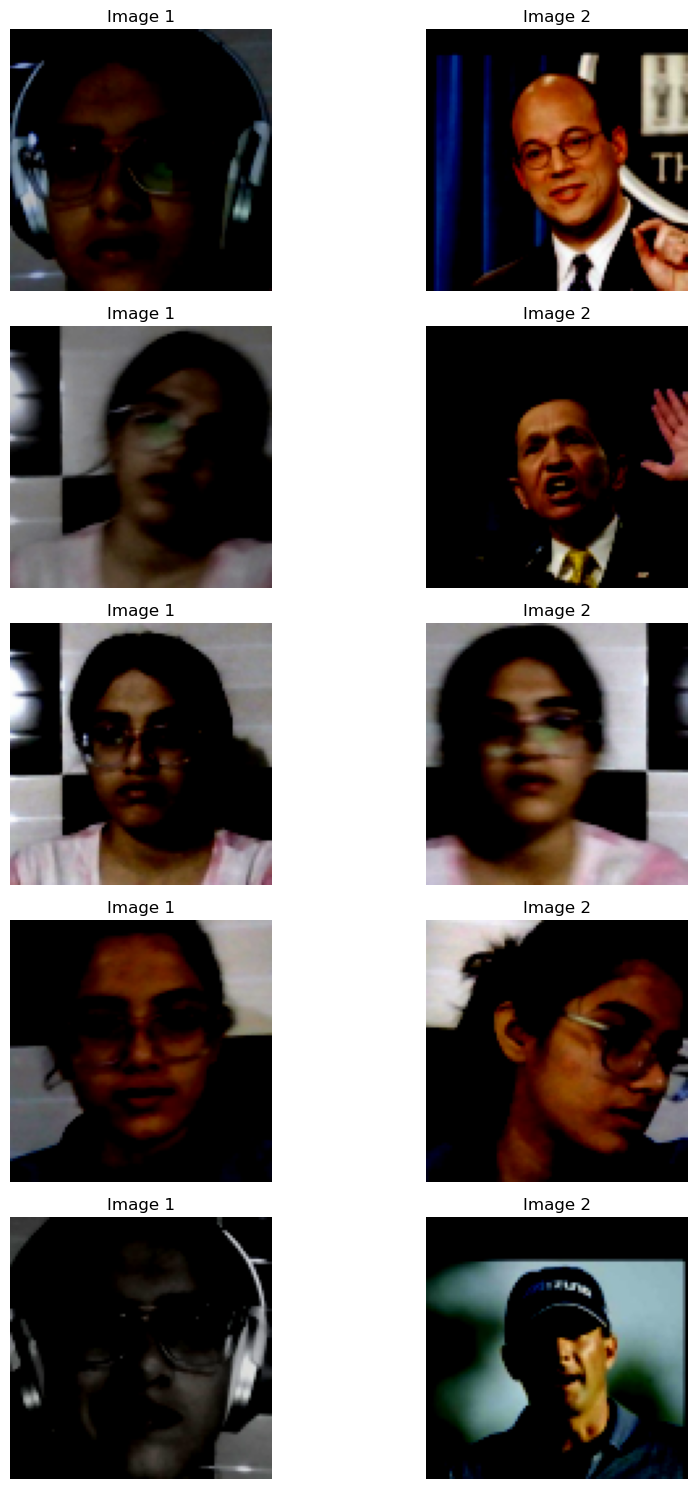

Labels: [0 0 1 1 0]


In [32]:
import matplotlib.pyplot as plt

def visualize_train_data_loader(train_data_loader, num_samples=5):
    # Get one batch of data
    for i, (img1, img2, labels) in enumerate(train_data_loader):
        # Plot the images
        fig, axes = plt.subplots(num_samples, 2, figsize=(10, num_samples * 3))
        
        for idx in range(num_samples):
            if idx >= len(img1):  # Prevent errors if there are fewer images in the batch
                break
            # Show first image
            print(f"Shape of img1[idx]: {img1[idx].shape}")  # Debug shape
            print(f"Shape of img2[idx]: {img2[idx].shape}")

            image1 = img1[idx].squeeze(0).numpy().transpose(1, 2, 0)  # Remove extra dimension, (C, H, W) -> (H, W, C)
            image2 = img2[idx].squeeze(0).numpy().transpose(1, 2, 0)
            
            # Show first image
            axes[idx, 0].imshow(image1)
            axes[idx, 0].axis('off')
            axes[idx, 0].set_title("Image 1")
            
            # Show second image
            axes[idx, 1].imshow(image2)
            axes[idx, 1].axis('off')
            axes[idx, 1].set_title("Image 2")

        plt.tight_layout()
        plt.show()
        
        # Print labels
        print("Labels:", labels[:num_samples].numpy())

        # Stop after visualizing the required number of samples
        if i == 0:
            break

# Call the function with your train_data_loader
visualize_train_data_loader(train_data_loader)


Create Siamese Network Model

In [9]:
import torch.nn as nn
import torch.nn.functional as F

class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        
        # Shared feature extractor
        self.conv1 = nn.Conv2d(3, 64, kernel_size=10, stride=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=7, stride=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=4, stride=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=4, stride=1)
        self.fc1 = nn.Linear(256 * 5 * 5, 4096)

        # L1 Distance layer
        self.l1_distance = nn.PairwiseDistance(p=1)

        # Classifier
        self.fc2 = nn.Linear(4096, 1)  # Single output for similarity
        self.sigmoid = nn.Sigmoid()

    def forward_one(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = F.relu(self.conv4(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return x

    def forward(self, input1, input2):
        # Generate embeddings for both inputs
        embedding1 = self.forward_one(input1)
        embedding2 = self.forward_one(input2)
        
        # Compute L1 Distance
        distance = torch.abs(embedding1 - embedding2)
        
        # Classifier
        output = self.sigmoid(self.fc2(distance))
        return output


Testing model

In [10]:
# Define model, optimizer, and loss
model = SiameseNetwork()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

input1 = torch.randn(16, 3, 100, 100)  # Batch of anchor images
input2 = torch.randn(16, 3, 100, 100)  # Batch of comparison images
labels = torch.randint(0, 2, (16, 1)).float()  # Binary labels (0: dissimilar, 1: similar)

output = model(input1, input2)

loss = criterion(output, labels)

optimizer.zero_grad()
loss.backward()
optimizer.step()

print(f"Loss: {loss.item()}")


Loss: 0.692844033241272


Training and evaluation loops

In [11]:
from tqdm import tqdm

In [12]:
model = SiameseNetwork()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import torch


In [14]:
import numpy as np
import pandas as pd

def evaluate_siamese_network(model, data_loader, device, save_predictions=False, output_file="predictions.csv"):
    model.eval()  # Set the model to evaluation mode
    all_labels = []
    all_preds = []
    all_pred_probs = []  # Store the raw probabilities for all predictions
    all_true_labels = []  # Store true labels for comparison

    with torch.no_grad():  # Disable gradient computation for inference
        for img1, img2, labels in data_loader:
            img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)

            # Forward pass
            outputs = model(img1, img2).squeeze()  # Squeeze to ensure the output is 1D
            preds = (outputs > 0.5).float()  # Convert to binary prediction (0 or 1)

            # Store true labels and predictions
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_pred_probs.extend(outputs.cpu().numpy()) 
            all_true_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)

    predictions_df = pd.DataFrame({
        "True Label": all_true_labels,
        "Predicted Class": all_preds,
        "Predicted Probability": all_pred_probs
    })

    if save_predictions:
        predictions_df.to_csv(output_file, index=False)
        print(f"Predictions saved to {output_file}")

    return accuracy, precision, recall, f1, cm, predictions_df


In [15]:
def train_siamese_network(model, train_loader, criterion, optimizer, num_epochs=10, device="cuda", save_predictions=False):
    model = model.to(device)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for img1, img2, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            img1, img2, labels = img1.to(device), img2.to(device), labels.to(device).float()

            # Forward pass
            outputs = model(img1, img2).squeeze()
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)
        
        accuracy, precision, recall, f1, cm, predictions_df = evaluate_siamese_network(model, train_loader, device, save_predictions=save_predictions)

        print(f"Epoch [{epoch+1}/{num_epochs}]")
        print(f"Train Loss: {train_loss:.4f} | Accuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1-score: {f1:.4f}")
        print(f"Confusion Matrix:\n{cm}")

    print("Training complete!")
    return predictions_df


In [16]:
train_siamese_network(
    model=model,
    train_loader=train_data_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=3,
    device="cuda" if torch.cuda.is_available() else "cpu"
)

Epoch 1/3: 100%|██████████| 361/361 [10:00<00:00,  1.66s/it]


Epoch [1/3]
Train Loss: 0.1823 | Accuracy: 0.9919 | Precision: 0.9915 | Recall: 0.9964 | F1-score: 0.9939
Confusion Matrix:
[[3770   66]
 [  28 7686]]


Epoch 2/3: 100%|██████████| 361/361 [10:29<00:00,  1.74s/it]


Epoch [2/3]
Train Loss: 0.0638 | Accuracy: 0.9984 | Precision: 0.9977 | Recall: 1.0000 | F1-score: 0.9988
Confusion Matrix:
[[3818   18]
 [   0 7714]]


Epoch 3/3: 100%|██████████| 361/361 [11:29<00:00,  1.91s/it]


Epoch [3/3]
Train Loss: 0.0765 | Accuracy: 0.9719 | Precision: 0.9797 | Recall: 0.9781 | F1-score: 0.9789
Confusion Matrix:
[[3680  156]
 [ 169 7545]]
Training complete!


,True Label,Predicted Class,Predicted Probability
0,0,0.0,0.000000
1,1,1.0,0.923434
2,0,0.0,0.000000
3,1,1.0,1.000000
4,0,0.0,0.000000
...,...,...,...
11545,1,1.0,0.999895
11546,1,1.0,1.000000
11547,0,1.0,0.973401
11548,1,1.0,0.999994


In [19]:
evaluate_siamese_network(
    model = model,
    data_loader = test_data_loader, 
    device = device, 
    save_predictions=False, 
    output_file="predictions.csv"
)

(0.9757575757575757,
 0.9843941248470012,
 0.9790018259281802,
 0.9816905706438815,
 array([[1613,   51],
        [  69, 3217]], dtype=int64),
       True Label  Predicted Class  Predicted Probability
 0              1              1.0           9.999995e-01
 1              1              1.0           9.999934e-01
 2              1              1.0           1.000000e+00
 3              1              1.0           1.000000e+00
 4              0              0.0           5.996068e-29
 ...          ...              ...                    ...
 4945           1              1.0           9.999980e-01
 4946           0              0.0           0.000000e+00
 4947           0              0.0           0.000000e+00
 4948           0              0.0           6.909815e-27
 4949           1              1.0           1.000000e+00
 
 [4950 rows x 3 columns])

Saving Model

In [20]:
# Save only the model weights (state_dict)
torch.save(model.state_dict(), "siamese_model_normalized.pth")


In [21]:
# Create the model instance (ensure the architecture matches)
model = SiameseNetwork()  # Replace with your model class

# Load the weights
model.load_state_dict(torch.load("siamese_model_normalized.pth"))

# Move to the correct device (CPU or GPU)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

SiameseNetwork(
  (conv1): Conv2d(3, 64, kernel_size=(10, 10), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(128, 128, kernel_size=(4, 4), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1))
  (fc1): Linear(in_features=6400, out_features=4096, bias=True)
  (l1_distance): PairwiseDistance()
  (fc2): Linear(in_features=4096, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [22]:
model = SiameseNetwork()  # Replace with your custom model class


In [33]:
model.load_state_dict(torch.load("siamese_model_normalized.pth"))


<All keys matched successfully>

In [34]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)


SiameseNetwork(
  (conv1): Conv2d(3, 64, kernel_size=(10, 10), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(128, 128, kernel_size=(4, 4), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1))
  (fc1): Linear(in_features=6400, out_features=4096, bias=True)
  (l1_distance): PairwiseDistance()
  (fc2): Linear(in_features=4096, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [35]:
for test_input, test_val, labels in test_data_loader:
    # Move to device
    test_input, test_val = test_input.to(device), test_val.to(device)

    # Now you can pass these to the model
    with torch.no_grad():
        predictions = model(test_input, test_val)


In [36]:
predictions

tensor([[9.9997e-01],
        [1.0000e+00],
        [0.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [0.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [9.9983e-01],
        [9.9997e-01],
        [0.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [6.9098e-27],
        [1.0000e+00]])

Real Time

In [37]:
# application_data\verification_images

In [26]:
os.listdir(os.path.join('application_data', 'verification_images'))

['0d198288-b49a-11ef-8dbd-60e9aab7d05e.jpg',
 '0d59e847-b49a-11ef-a8d6-60e9aab7d05e.jpg',
 '0e1b80da-b49a-11ef-8168-60e9aab7d05e.jpg',
 '0e3829bf-b49a-11ef-bbad-60e9aab7d05e.jpg',
 '0e54e09c-b49a-11ef-baf6-60e9aab7d05e.jpg',
 '0e9572d8-b49a-11ef-b895-60e9aab7d05e.jpg',
 '0f891b6b-b49a-11ef-abdd-60e9aab7d05e.jpg',
 '0fc99813-b49a-11ef-9dd1-60e9aab7d05e.jpg',
 '1a0ea58c-b49a-11ef-837c-60e9aab7d05e.jpg',
 '1a2b49b0-b49a-11ef-879f-60e9aab7d05e.jpg',
 '1a499c2c-b499-11ef-9fb0-60e9aab7d05e.jpg',
 '1a68f6b8-b49a-11ef-87e2-60e9aab7d05e.jpg',
 '1bf60d42-b49a-11ef-ba25-60e9aab7d05e.jpg',
 '1c075bed-b499-11ef-8af4-60e9aab7d05e.jpg',
 '1c5cfcd9-b49a-11ef-9a06-60e9aab7d05e.jpg',
 '1ccea5fc-b49a-11ef-94f3-60e9aab7d05e.jpg',
 '1da5c12a-b499-11ef-a464-60e9aab7d05e.jpg',
 '1db7a78b-b49a-11ef-9faf-60e9aab7d05e.jpg',
 '1e5bc68a-b49a-11ef-a8e2-60e9aab7d05e.jpg',
 '1ec79987-b49a-11ef-8f63-60e9aab7d05e.jpg',
 '1ed0964f-b499-11ef-b3db-60e9aab7d05e.jpg',
 '1ef272ea-b49a-11ef-9db6-60e9aab7d05e.jpg',
 '1f882f79

In [35]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data\\input_image\\input_image.jpg'

In [36]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data\verification_images\0d198288-b49a-11ef-8dbd-60e9aab7d05e.jpg
application_data\verification_images\0d59e847-b49a-11ef-a8d6-60e9aab7d05e.jpg
application_data\verification_images\0e1b80da-b49a-11ef-8168-60e9aab7d05e.jpg
application_data\verification_images\0e3829bf-b49a-11ef-bbad-60e9aab7d05e.jpg
application_data\verification_images\0e54e09c-b49a-11ef-baf6-60e9aab7d05e.jpg
application_data\verification_images\0e9572d8-b49a-11ef-b895-60e9aab7d05e.jpg
application_data\verification_images\0f891b6b-b49a-11ef-abdd-60e9aab7d05e.jpg
application_data\verification_images\0fc99813-b49a-11ef-9dd1-60e9aab7d05e.jpg
application_data\verification_images\1a0ea58c-b49a-11ef-837c-60e9aab7d05e.jpg
application_data\verification_images\1a2b49b0-b49a-11ef-879f-60e9aab7d05e.jpg
application_data\verification_images\1a499c2c-b499-11ef-9fb0-60e9aab7d05e.jpg
application_data\verification_images\1a68f6b8-b49a-11ef-87e2-60e9aab7d05e.jpg
application_data\verification_images\1bf60d42-b49a-11ef-ba25-60e

In [42]:
def preprocess_image(img_path):
    transform = transforms.Compose([
        transforms.Resize((100, 100)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = Image.fromarray(img)
    return transform(img).unsqueeze(0)

In [40]:
# def verify(self, *args):
#         # Specify thresholds
#         # detection_threshold = 0.99
#         # verification_threshold = 0.8

#         # Build results array
#         results = []
#         for image in os.listdir(os.path.join('application_data', 'verification_images')):
#             input_img = self.preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
#             input_batch = input_img.repeat(len(verification_images), 1, 1, 1)
#             # validation_img = self.dataset.preprocess(os.path.join('application_data', 'verification_images', image))
#             validation_batch = torch.cat([dataset.preprocess(img).unsqueeze(0) for img in verification_images], dim=0)
#             # Make predictions
#             with torch.no_grad():
#                 result = self.model(input_img, validation_img).item()
#             results.append(result)

#         # Detection Threshold: Metric above which a prediction is considered positive
#         detection = np.sum(np.array(results) > detection_threshold)

#         # Verification Threshold: Proportion of positive predictions / total positive samples
#         verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images')))
#         verified = verification > verification_threshold

#         return results, verified

In [43]:
def verify(model, detection_threshold=0.99, verification_threshold=0.8):
    verification_images = [os.path.join('application_data', 'verification_images', img)
                           for img in os.listdir(os.path.join('application_data', 'verification_images'))
                           if img.endswith(('.jpg', '.png'))]

    input_img = preprocess_image(os.path.join('application_data', 'input_image', 'input_image.jpg'))
    input_batch = input_img.repeat(len(verification_images), 1, 1, 1)

    validation_batch = torch.cat(
        [preprocess_image(img) for img in verification_images], dim=0
    )

    with torch.no_grad():
        results = model(input_batch, validation_batch).squeeze().tolist()

    detection = np.sum(np.array(results) > detection_threshold)
    verification = detection / len(verification_images)
    verified = verification > verification_threshold

    return results, verified


In [45]:
# cap = cv2.VideoCapture(0)
# while cap.isOpened():
#     ret, frame = cap.read()
#     frame = frame[120:120+250,200:200+250, :]
    
#     cv2.imshow('Verification', frame)
    
#     # Verification trigger
#     if cv2.waitKey(10) & 0xFF == ord('v'):
#         # Save input image to application_data/input_image folder 
#         cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
#         # Run verification
#         results, verified = verify(model, 0.9, 0.7)
#         print(verified)
    
#     if cv2.waitKey(10) & 0xFF == ord('q'):
#         break
# cap.release()
# cv2.destroyAllWindows()

False
True


In [46]:
cap = cv2.VideoCapture(0)  # Open webcam
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        print("Failed to capture frame.")
        break

    # Crop and display the frame
    frame = frame[120:120+250, 200:200+250, :]
    cv2.imshow('Verification', frame)

    # Trigger verification on pressing 'v'
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save the captured frame to the input image directory
        input_image_path = os.path.join('application_data', 'input_image', 'input_image.jpg')
        cv2.imwrite(input_image_path, frame)

        # Display the saved input image
        saved_frame = cv2.imread(input_image_path)
        cv2.imshow("Saved Input Image", saved_frame)

        # Run verification and print results
        results, verified = verify(model, 0.9, 0.7)
        print(f"Verification Results: {results}")
        print(f"Verified: {verified}")

    # Quit the program on pressing 'q'
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

Verification Results: [0.9999998807907104, 0.9999103546142578, 1.0, 1.0, 0.999935507774353, 0.9999966621398926, 0.9999454021453857, 1.0, 0.9999175071716309, 0.9999998807907104, 0.9999980926513672, 0.9999500513076782, 0.9999967813491821, 0.9999819993972778, 0.9990886449813843, 0.9998427629470825, 0.9999988079071045, 4.0699505916563794e-05, 0.9936329126358032, 0.9999960660934448, 1.0, 0.9862322211265564, 0.999998927116394, 0.9999983310699463, 1.0, 1.0, 1.0, 1.0, 0.8918212652206421, 0.9838426113128662]
Verified: True
